__NOTE:__ For transforming the bboxes by albumentations library make sure you convert the bbox into 'coco' format which is [x_min, y_min, width, height], since it is the most stable. On repeated experimentation it was found that 'yolo' and 'pascal_voc' seems to be broken.

# Importing Library

In [1]:
import torch
from torch import nn
from torch import optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import selectivesearch
import os
from tqdm import tqdm
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters

In [2]:
img_aug_p = 0.5
iou_threshold = 0.4

# Helper Functions

In [3]:
# Ref: https://albumentations.ai/docs/examples/example_bboxes/
def draw_bounding_boxes(image, bbox, category):
    x_1, y_1, width, height = bbox
    x_1, y_1, x_2, y_2 = int(x_1), int(y_1), int(x_1 + width), int(y_1 + height)
    cv2.rectangle(image, (x_1, y_1), (x_2, y_2), (255, 0, 0), thickness=2, lineType = cv2.LINE_AA)
    ((text_width, text_height), _) = cv2.getTextSize(category, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(image, (x_1, y_1 - int(1.3 * text_height)), (x_1 + text_width, y_1), (0, 0, 0), -1)
    cv2.putText(image, category, (x_1, y_1 - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255))
    return image

def visualize_bbox(image, bboxes, category_idxs, idx_to_cat):
    img = image.copy()
    for bbox, category_idx in zip(bboxes, category_idxs):
        category = idx_to_cat[category_idx]
        img = draw_bounding_boxes(img, bbox, category)
    plt.figure(figsize = (8,8))
    plt.imshow(img)
    plt.axis('off')

def extract_regions(img, scale = 100):
    _, regions = selectivesearch.selective_search(img, scale = scale, min_size=100)
    candidates = []
    total_area = np.prod(img.shape[:2])
    for region in regions:
        if region['rect'] in candidates:
            continue
        # Remove rectangle which is less than 5% of total image area or greater than image
        elif region['size'] < (0.05*total_area):
            continue
        elif region['size'] > (1*total_area):
            continue
        candidates.append(region['rect'])
    return candidates

def calculate_iou(box_1, box_2, epsilon = 1e-06):
    iou = 0.0
    box_1_area = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])
    box_2_area = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])
    x1_inter = max(box_1[0], box_2[0])
    y1_inter = max(box_1[1], box_2[1])
    x2_inter = min(box_1[2], box_2[2])
    y2_inter = min(box_1[3], box_2[3])
    inter_width = (x2_inter - x1_inter)
    inter_height = (y2_inter - y1_inter)
    if (inter_height < 0 or inter_width < 0):
        return 0.0
    inter_area = inter_width*inter_height
    union_area = box_1_area - box_2_area - inter_area
    iou = inter_area/(union_area + epsilon)
    return iou

# Loading Data and Visualization

In [4]:
base_folder = pathlib.Path('data/coco')
train_image_folder = base_folder/'train2017'
valid_image_folder = base_folder/'val2017'
train_csv = pd.read_csv(base_folder/'train.csv')
valid_csv = pd.read_csv(base_folder/'valid.csv')
train_csv['path'] = list(map(lambda x:train_image_folder/x, train_csv['file_name']))
# Transforming width and height column to width and height of the bounding box
train_csv['width'] = train_csv['x_2'].values - train_csv['x_1'].values
train_csv['height'] = train_csv['y_2'].values - train_csv['y_1'].values

# Valid
valid_csv['path'] = list(map(lambda x:valid_image_folder/x, valid_csv['file_name']))
# Transforming width and height column to width and height of the bounding box
valid_csv['width'] = valid_csv['x_2'].values - valid_csv['x_1'].values
valid_csv['height'] = valid_csv['y_2'].values - valid_csv['y_1'].values
train_csv.head()

,image_id,file_name,width,height,x_1,y_1,x_2,y_2,category_idx,category_name,path
0,9,000000000009.jpg,75,46,376,40,451,86,55,orange,data/coco/train2017/000000000009.jpg
1,9,000000000009.jpg,58,47,465,38,523,85,55,orange,data/coco/train2017/000000000009.jpg
2,9,000000000009.jpg,320,228,311,4,631,232,51,bowl,data/coco/train2017/000000000009.jpg
3,9,000000000009.jpg,316,245,249,229,565,474,56,broccoli,data/coco/train2017/000000000009.jpg
4,9,000000000009.jpg,94,71,364,2,458,73,55,orange,data/coco/train2017/000000000009.jpg


In [5]:
idx_to_cat = set(train_csv.groupby(['category_idx', 'category_name']).groups)
idx_to_cat = dict(idx_to_cat)
idx_to_cat[0] = 'background'
cat_to_idx = {v:k for k,v in idx_to_cat.items()}
print(idx_to_cat)

{31: 'handbag', 44: 'bottle', 39: 'baseball bat', 87: 'scissors', 56: 'broccoli', 75: 'remote', 2: 'bicycle', 37: 'sports ball', 79: 'oven', 52: 'banana', 72: 'tv', 57: 'carrot', 6: 'bus', 50: 'spoon', 42: 'surfboard', 24: 'zebra', 8: 'truck', 13: 'stop sign', 27: 'backpack', 78: 'microwave', 17: 'cat', 61: 'cake', 32: 'tie', 65: 'bed', 23: 'bear', 88: 'teddy bear', 15: 'bench', 1: 'person', 25: 'giraffe', 4: 'motorcycle', 53: 'apple', 60: 'donut', 89: 'hair drier', 63: 'couch', 11: 'fire hydrant', 58: 'hot dog', 9: 'boat', 54: 'sandwich', 43: 'tennis racket', 16: 'bird', 5: 'airplane', 22: 'elephant', 35: 'skis', 51: 'bowl', 90: 'toothbrush', 20: 'sheep', 85: 'clock', 41: 'skateboard', 64: 'potted plant', 62: 'chair', 10: 'traffic light', 76: 'keyboard', 19: 'horse', 81: 'sink', 40: 'baseball glove', 47: 'cup', 70: 'toilet', 48: 'fork', 59: 'pizza', 28: 'umbrella', 14: 'parking meter', 82: 'refrigerator', 21: 'cow', 86: 'vase', 74: 'mouse', 77: 'cell phone', 46: 'wine glass', 80: 'toa

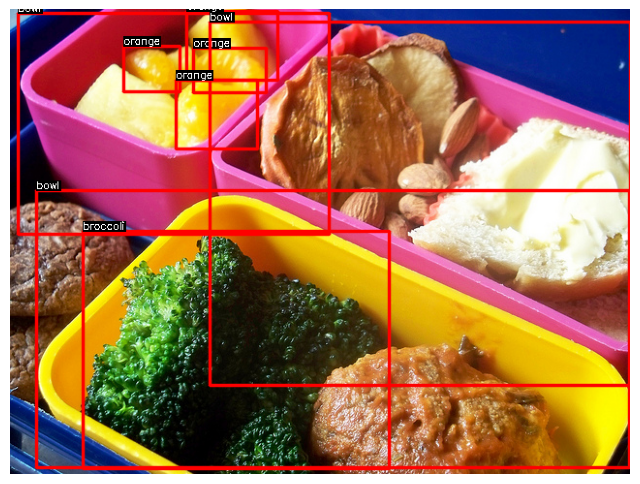

In [6]:
# Checking Transformation
transforms = A.Compose([A.HorizontalFlip(p = img_aug_p),
                        A.ShiftScaleRotate(p = img_aug_p)],
                       bbox_params=A.BboxParams('coco', label_fields=['category_idx']))
idx = 0
file_name = train_csv['file_name'].iloc[idx]
df_sub = train_csv[train_csv['file_name'] == file_name].copy()
file_path = train_image_folder/file_name
img = cv2.imread(str(file_path), cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bboxes = df_sub[['x_1', 'y_1', 'width', 'height']].values.tolist()
category_idx = df_sub['category_idx'].values.tolist()
transformed = transforms(image = img, bboxes = bboxes, category_idx=category_idx)
visualize_bbox(transformed['image'], transformed['bboxes'], transformed['category_idx'], idx_to_cat)

In [7]:
class COCOData(Dataset):
    def __init__(self, df):
        self.df = df
        self.unique_ids = df['image_id'].unique()

    def __len__(self):
        return len(self.unique_ids)
    
    def __getitem__(self, idx):
        image_id = self.unique_ids[idx]
        df_sub = self.df[self.df['image_id'] == image_id]
        # Since all path are same for subset
        file_path = df_sub['path'].iloc[0]
        image = cv2.imread(str(file_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bboxes = df_sub[['x_1', 'y_1', 'x_2', 'y_2']].values
        bboxes_dim = df_sub[['width', 'height']].values
        classes = df_sub['category_name'].values.tolist()
        return image, bboxes, classes, bboxes_dim, file_path
    
train_coco = COCOData(train_csv)
valid_coco = COCOData(valid_csv)

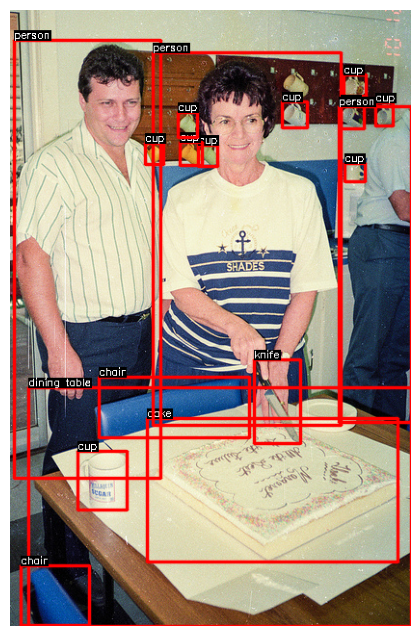

In [8]:
idx = 22
img, bboxes, classes, bboxes_dim, _ = train_coco[idx]
# Visualization takes bbox in format (x_1, y_1, w, h) and category idxs
# Removing x_2, y_2 with width and height
display_bb = np.hstack((bboxes[:, :2], bboxes_dim))
# Getting category idxs for purposes of visualization
category_idxs = [cat_to_idx[cat] for cat in classes]
visualize_bbox(img, display_bb, category_idxs, idx_to_cat)

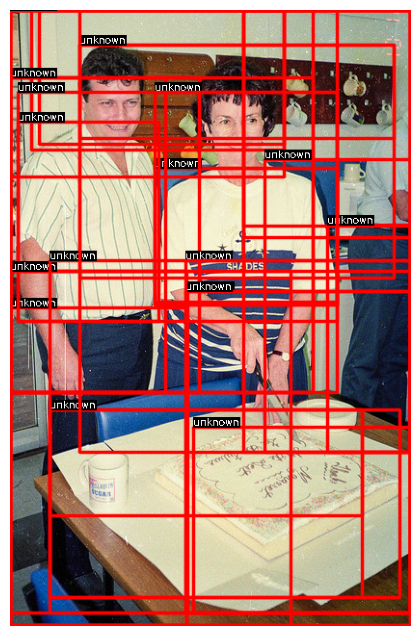

In [9]:
# Checking Region Proposals
candidates = extract_regions(img)
visualize_bbox(img, candidates, [0 for i in candidates], {0:'unknown'})

In [10]:
# Calculating IoU for each proposed candidate
candidates = np.array([(x, y, x + w, y + h) for x, y, w, h in candidates])
ious = np.array([[calculate_iou(bb, candidate) for bb in bboxes] for candidate in candidates])

In [11]:
print(f"No of Train Images: {len(train_coco)}")
print(f"No of Test Images: {len(valid_coco)}")

No of Train Images: 117266
No of Test Images: 4952


In [12]:
# Storing the proposed region and their corresponding label and iou for purposes of training
fpaths, ground_truths, proposed_regions, ious, labels, offsets= [], [], [], [], [], []
# Taking N no of images from entire dataset
N = 1000
for i in tqdm(range(N)):
    img, bboxes, classes, bboxes_dim, file_path = train_coco[i]
    H, W = img.shape[:2]
    candidates = extract_regions(img)
    candidates = np.array([(x, y, x+w, y+h) for x,y,w,h in candidates])
    iou = np.array([[calculate_iou(bb, candidate) for bb in bboxes] for candidate in candidates])
    current_rois, current_lbls, current_offsets = [], [], []
    for idx, candidate in enumerate(candidates):
        c_x_1, c_y_1, c_x_2, c_y_2 = candidate
        candidate_iou = iou[idx]
        best_iou = np.argmax(candidate_iou)
        iou_value = candidate_iou[best_iou]
        bbox = bboxes[best_iou]
        if iou_value > iou_threshold:
            current_lbls.append(classes[best_iou])
        else:
            current_lbls.append('background')

        # Make them in proportion to the image size
        current_offset = np.array([bbox[0] - c_x_1, bbox[1] - c_y_1, bbox[2] - c_x_2, bbox[3] - c_y_2]) / np.array([W, H, W, H])
        current_roi = candidate / np.array([W, H, W, H])
        current_offsets.append(current_offset)
        current_rois.append(current_roi)
    fpaths.append(file_path)
    ground_truths.append(bboxes)
    ious.append(iou)
    proposed_regions.append(current_rois)
    labels.append(current_lbls)
    offsets.append(current_offsets)

  0%|          | 1/1000 [00:02<43:30,  2.61s/it]